In [3]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm.auto import tqdm
import random
import time
import multiprocessing as mp
import numpy as np
import random
import time
import multiprocessing as mp
import numpy as np
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

maps =  ["project4_EP/sourceNotebooks/data/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits"]

for x in range(len(maps)):
    beam = 10
    filepath = maps[x]

    pl = hp.read_map(filepath)
    pl[pl<-1e23]=0
    shape,wcs = enmap.fullsky_geometry(res=int(beam)*utils.arcmin,proj='car')
    map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)

    awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/src/wh22.csv', skiprows = 0)
    awd_not_psz = awd_not_psz[awd_not_psz.z<1.0]

    stacks = []
    lens = []
    riches = []
    reds = []

    stack_CMB_kSZ           = 0
    stack_CMB_kSZ_deproject = 0
    c = 0

    ras = awd_not_psz['ra'].reset_index(drop=True)
    decs = awd_not_psz['dec'].reset_index(drop=True)
    N = len(ras)
    lens.append(N)

    for i in tqdm(range(N)):
        stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=beam*utils.arcmin)
        if stamp is None:
            continue
        elif stamp[0][0][0]==0.0:
            continue
        else:
            stack_CMB_kSZ += np.array(stamp)
            c+=1

    # Normalize the stamps
    stack_CMB_kSZ /= c
    stack_CMB_kSZ_deproject /= c
    stacks.append(stack_CMB_kSZ[0])

    np.save('143_10_test_new.npy',stacks)
    np.savetxt('lens.txt',lens)

In [2]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

maps =  ["project4_EP/sourceNotebooks/data/act_dr5.01_s08s18_AA_f090_daynight_map.fits"]

for x in range(len(maps)):
    beam = 5
    filepath = maps[x]

#     pl = hp.read_map(filepath)
#     pl[pl<-1e23]=0
#     shape,wcs = enmap.fullsky_geometry(res=int(beam)*utils.arcmin,proj='car')
#     map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)
    map_pix = enmap.read_map(filepath)

    awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/src/wh22.csv', skiprows = 0)
    
    zs = [0, 0.72, 100]
    masses = [0, 1, 100000]

    stacks = []
    lens = []
    riches = []
    reds = []

    for j in tqdm(range(len(zs))):
        for k in range(len(masses)):
            stack_CMB_kSZ           = 0
            stack_CMB_kSZ_deproject = 0
            c = 0
            riches.append(masses[k])
            reds.append(zs[j])
            if j == len(zs)-1:
                if k == len(masses)-1:
                    ras = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['ra'].reset_index(drop=True)
                    decs = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['dec'].reset_index(drop=True)
                else:
                    ras = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['ra'].reset_index(drop=True)
                    decs = awd_not_psz[(awd_not_psz.z<zs[j]) & (awd_not_psz.z>0) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['dec'].reset_index(drop=True)
            elif k == len(masses)-1:
                ras = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['ra'].reset_index(drop=True)
                decs = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k]) & (awd_not_psz.m>=0)]['dec'].reset_index(drop=True)
            else:
                ras = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['ra'].reset_index(drop=True)
                decs = awd_not_psz[(awd_not_psz.z<zs[j+1]) & (awd_not_psz.z>zs[j]) & (awd_not_psz.m<masses[k+1]) & (awd_not_psz.m>=masses[k])]['dec'].reset_index(drop=True)

            N = len(ras)
            lens.append(N)

            for i in tqdm(range(N)):
                stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=beam*utils.arcmin)

                if stamp is None:
                    continue
                elif stamp[0][0][0]==0.0:
                    continue
                else:
                    stack_CMB_kSZ += np.array(stamp)
                    c+=1

            # Normalize the stamps
            stack_CMB_kSZ /= c
            stack_CMB_kSZ_deproject /= c

            stacks.append(stack_CMB_kSZ[0])
    np.save('090_all.npy'.format(x),stacks)
    np.savetxt('lens.txt',lens)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/28396 [00:00<?, ?it/s]

  0%|          | 0/31504 [00:00<?, ?it/s]

  0%|          | 0/75021 [00:00<?, ?it/s]

  0%|          | 0/22154 [00:00<?, ?it/s]

  0%|          | 0/38134 [00:00<?, ?it/s]

  0%|          | 0/76209 [00:00<?, ?it/s]

  0%|          | 0/50556 [00:00<?, ?it/s]

  0%|          | 0/69645 [00:00<?, ?it/s]

  0%|          | 0/151244 [00:00<?, ?it/s]

In [26]:
stacks = np.load('150_all_fix2.npy')
# stacks3 = np.load('220_all_fix2.npy')

# stacks[0] = stacks3[0]
# stacks[1] = stacks3[1]
# stacks[3] = stacks3[2]
# stacks[4] = stacks3[3]
# stacks[6] = stacks3[4]
# stacks[7] = stacks3[5]

lens = [35902,38207,75021,27954,47132,76209,63863,85346,151244]

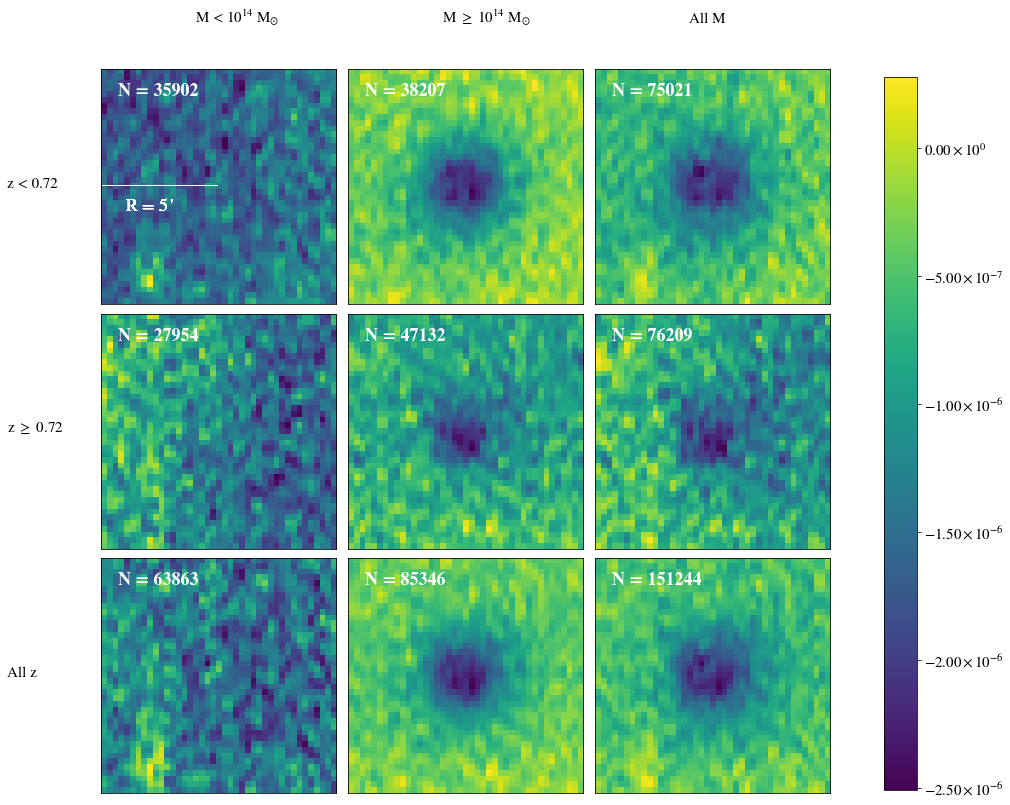

In [27]:
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

f, ax = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
i = 0

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for j,row in enumerate(ax):
    for k, col in enumerate(row):
        f1 = col.imshow(stacks[i]*1e-6)#, vmin=0.000729, vmax=0.000741)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
#         plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02)
#         cbar = plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02)
#         cbar.ax.tick_params(rotation=25)

        scalebar = AnchoredSizeBar(ax[0][0].transData,
                                   20, '', 'center left', 
                                   pad=0.,
                                   sep=-7,
                                   color='white',
                                   frameon=False,
                                   size_vertical=0.02)
        ax[0][0].add_artist(scalebar)
        ax[0][0].text(0.1, 0.4, 'R = 5$\,$\''.format(10), c='white', fontsize=18, transform=ax[0][0].transAxes)

        col.text(2.4,4.12,"N = {}".format(lens[i]),fontsize=18,color='white',weight=600)
#         if j==0 and k==0:
#             col.text(-15,20,"z<0.72",size=15)
#         if j==1 and k==0:
#             col.text(-15,20,"z>0.72",size=15)
#         if j==2 and k==0:
#             col.text(-15,20,"all z",size=15)
#         if k==0 and j==0:
#             col.text(15,-5,"M<1$M_{\astrosun}$",size=15)
#         if k==1 and j==0:
#             col.text(15,-5,"M>1$M_{\astrosun}$",size=15)
#         if k==2 and j==0:
#             col.text(15,-5,"all M",size=15)
        if j==0 and k==0:
            col.text(-.4,.5,"z < 0.72",size=15,transform=col.transAxes)
        if j==1 and k==0:
            col.text(-.4,.5,"z $\geq$ 0.72",size=15,transform=col.transAxes)
        if j==2 and k==0:
            col.text(-.4,.5,"All z",size=15,transform=col.transAxes)
        if k==0 and j==0:
            col.text(.4,1.2,"M < 10$^{14}$ M$_{\odot}$",size=15,transform=col.transAxes)
        if k==1 and j==0:
            col.text(.4,1.2,"M $\geq$ 10$^{14}$ M$_{\odot}$",size=15,transform=col.transAxes)
        if k==2 and j==0:
            col.text(.4,1.2,"All M",size=15,transform=col.transAxes)

        i+=1
    
f.subplots_adjust(right=0.8)
plt.subplots_adjust(wspace=0.05, hspace=-0.25)
cbar_ax = f.add_axes([0.85, 0.17, 0.03, 0.66])
cbar = f.colorbar(f1, cax=cbar_ax, format=FuncFormatter(fmt))
cbar.ax.tick_params(labelsize=15) 

plt.savefig("150.png")


In [15]:
len(awd_not_psz[awd_not_psz.m>=1])

87381

In [4]:
len(stacks[0])

41

In [4]:
awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/src/wh22.csv', skiprows = 0)

In [20]:
awd_not_psz

,Unnamed: 0,ra,dec,z,glat,glon
0,0,0.00200,2.31979,0.4192,-58.049452,98.087115
1,1,0.00555,-64.16639,0.6423,-52.047056,312.001004
2,2,0.00563,-52.33236,0.5829,-63.020377,320.368582
3,3,0.00943,-47.85358,0.7734,-66.974509,325.361169
4,4,0.01186,-47.73740,0.3169,-67.075474,325.508485
...,...,...,...,...,...,...
151239,151239,359.98911,-6.40920,1.0678,-65.938253,90.050298
151240,151240,359.99091,-44.66209,0.7684,-69.658934,330.042777
151241,151241,359.99377,-49.09889,0.6708,-65.887658,323.840195
151242,151242,359.99503,-37.71075,0.6743,-74.866209,345.359827


In [22]:
len(awd_not_psz[awd_not_psz.z<0.75])/len(awd_not_psz)

0.5320211049694533

In [62]:
def make_stacked_plots(all_stacks,all_beams,all_freqs):
    f, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    i = 0

    for j,row in enumerate(ax):
        for k, col in enumerate(row):    
            stacks = np.load(all_stacks[j*3+k])
            beam = all_beams[j*3+k]
            freq = all_freqs[j*3+k]
            
            if freq=='advACT 150 GHz':
                color='k'
                stacks[0] *= 1e-6
                linelen = 20
                linewid = 0.35
            else:
                if freq=='ROSAT':
                    color='k'
                else:
                    color='w'
                linelen = 2.5
                linewid = 0.04
                
            f1 = col.imshow(stacks[0])
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            fmt = lambda x, pos: '{:.2e}'.format(x)            
            cbar = plt.colorbar(mappable = f1, ax = col,orientation='horizontal',fraction=0.047, pad=0.02, format=FuncFormatter(fmt))
            cbar.ax.tick_params(rotation=25)

            scalebar = AnchoredSizeBar(col.transData,
                                       linelen, '', 'center right', 
                                       pad=0.,
                                       sep=-7,
                                       color='white',
                                       frameon=False,
                                       size_vertical=linewid)
            col.add_artist(scalebar)
            col.text(0.65, 0.42, 'R = {}\''.format(beam), c='white', transform=col.transAxes, fontsize=15)
            col.text(0.08,0.08,"{}".format(freq),color=color,transform=col.transAxes, fontsize=15)

            i+=1
            
    plt.subplots_adjust(wspace=-0.2, hspace=0.2)
    plt.savefig("stacked_lowres.png",bbox_inches='tight')
    plt.show()

In [67]:
beams = [10,5,10,10,10,5]
freqs = ['Planck 143 GHz','advACT 150 GHz','Planck 353 GHz','Planck 545 GHz','Planck 857 GHz','ROSAT']
files = ['143_10_new.npy','act_stacked_5_test2_150.npy','353_10_new.npy','545_10_new.npy','857_10_new.npy','rosat_stacked_test2_5.npy']

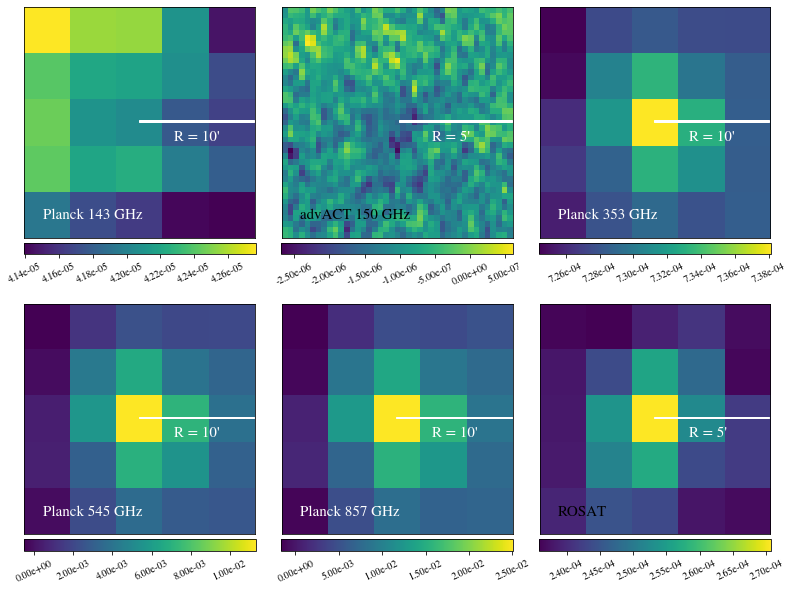

In [68]:
make_stacked_plots(files,beams,freqs)

In [20]:
awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/src/awd.csv', skiprows = 0)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

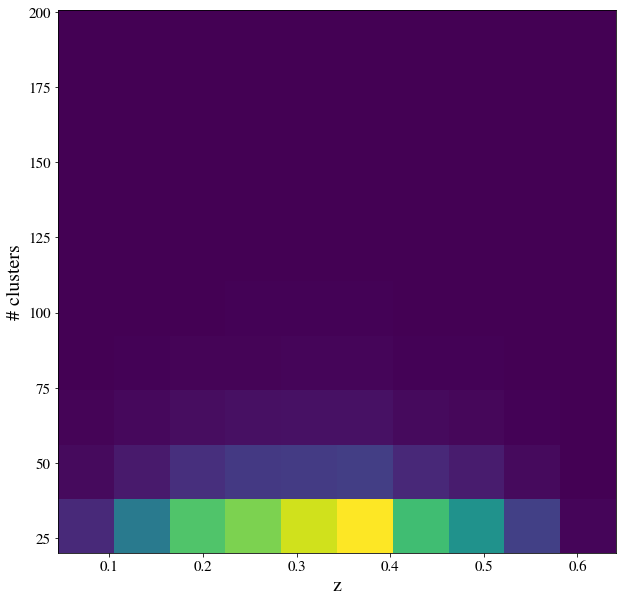

In [49]:
plt.figure(figsize=(10,10))
plt.hist2d(awd_not_psz.amf_z,awd_not_psz.amf_rh)
plt.ylabel('# clusters',size=20)
plt.xlabel('z',size=20)
plt.xticks(size=15)
plt.yticks(size=15)

In [48]:
len(awd_not_psz[awd_not_psz.amf_z>0.33])

15230

In [218]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

maps =  ['project4_EP/sourceNotebooks/data/HFI_SkyMap_857-field-Int_2048_R3.00_full.fits']

for x in range(len(maps)):
    beam = 10
    filepath = maps[x]

    pl = hp.read_map(filepath)
    pl[pl<-1e23]=0
    shape,wcs = enmap.fullsky_geometry(res=int(beam)*utils.arcmin,proj='car')
    map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)

    awd_not_psz = pd.read_csv('project4_EP/sourceNotebooks/data/new/awd_not_psz.csv', skiprows = 0)

    stacks = []
    lens = []
    riches = []
    reds = []

    stack_CMB_kSZ           = 0
    stack_CMB_kSZ_deproject = 0
    c = 0

    ras = awd_not_psz['amf_ra']
    decs = awd_not_psz['amf_dec']
    N = len(ras)
    lens.append(N)

    for i in tqdm(range(N)):
        dust = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=30*utils.arcmin)
        stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=beam*utils.arcmin)
        if stamp is None:
            continue
        elif stamp[0][0][0]==0.0:
            continue
        elif dust is None:
            continue
        elif dust[0][0][0]==0.0:
            continue
        else:
            dust_sum = sum(sum(dust[0]))
            num_pix_dust = len(dust[0][0])*len(dust[0][0])            
            stack_CMB_kSZ += (np.array(stamp)-(dust_sum/num_pix_dust))
            c+=1

    # Normalize the stamps
    stack_CMB_kSZ /= c
    stack_CMB_kSZ_deproject /= c
    stacks.append(stack_CMB_kSZ[0])

    np.save('857_10_.npy',stacks)
    np.savetxt('lens.txt',lens)


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128


KeyboardInterrupt: 

In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np
import pandas as pd

desi = hp.read_map('project4_EP/overlaps/masks/DESI.fits')
act = hp.read_map('project4_EP/overlaps/masks/AdvACT.fits')

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [2]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["whitesmoke", "yellow", "steelblue", "mediumseagreen"], "overlap")

In [17]:
import numpy as np
import fitsio
pixweight = fitsio.read('pixweight-1-dark.fits')
depth = -2.5*(np.log10((5/np.sqrt(pixweight['GALDEPTH_R'])))-9)

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


ValueError: Wrong pixel number (it is not 12*nside**2)

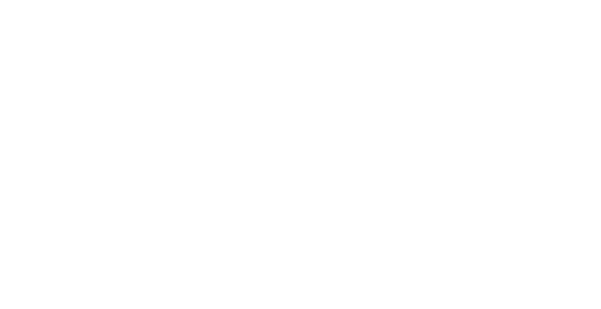

In [48]:
map_test = hp.pix2ang(nside=256,ipix=pixweight['HPXPIXEL'])
hp.mollview(map_test)

In [35]:
len(pixweight['HPXPIXEL'])

786432

In [43]:
12*(256**2)

786432

In [19]:
len(depth)

786432

In [23]:
len(overlap_mask)

49152

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/projaxes.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


NameError: name 'Bs' is not defined

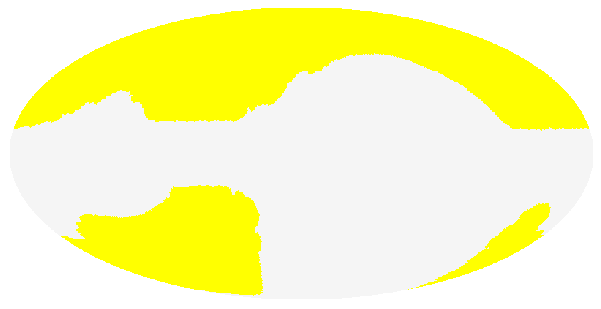

In [3]:
overlap_mask = desi + 2*act

# overlap_fsky = get_fsky(overlap_only_mask)
# st.text(f"Overlap f_sky = {overlap_fsky:.2f}")

hp.mollview(desi,coord=['C','G'], fig=2, cmap=cmap, max=3, cbar=False, notext=True, title=None)
hp.projscatter(Bs.x,)
hp.graticule(alpha=0.5)       
# plt.grid()
# hp.projtext(-0.9,-0.5,'DESI',size=20)
# hp.projtext(8.9,-10.,'Intersection',size=20)
# hp.projtext(9.1,12,'advACT',size=20)
plt.savefig('coverage.png',dpi=1080)

In [4]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
import random
import time
import multiprocessing as mp
import numpy as np
import random
import time
import multiprocessing as mp
import numpy as np


def import_map(filepath, beam):
    pl = hp.read_map(filepath)
    pl[pl<-1e23]=0
    try:
        shape,wcs = enmap.fullsky_geometry(res=int(beam)*utils.arcmin,proj='car')
        map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)
    except:
        shape,wcs = enmap.fullsky_geometry(res=int(beam+1)*utils.arcmin,proj='car')
        map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)
    return map_pix


def extract_intensity(map_pix, ras, decs, beam):
    N = len(ras)
    stack_CMB_kSZ           = 0
    stack_CMB_kSZ_deproject = 0
    c = 0

    signal = []
    ras_used = []
    decs_used = []
    for i in tqdm(range(N)):
        dust = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=30*utils.arcmin)
        stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=beam*utils.arcmin)
        if stamp is None:
            signal.append(-9999)
        elif stamp[0][0][0]==0.0:
            signal.append(-9999)
        elif dust is None:
            signal.append(-9999)
        elif dust[0][0][0]==0.0:
            signal.append(-9999)
        else:
            dust_sum = sum(sum(dust[0]))
            num_pix_dust = len(dust[0][0])*len(dust[0][0])
            signal_sum = sum(sum(stamp[0]))
            num_pix_signal = len(stamp[0][0])*len(stamp[0][0])
            signal.append((signal_sum/num_pix_signal)-(dust_sum/num_pix_dust))
        ras_used.append(ras[i])
        decs_used.append(decs[i])

    return signal, ras_used, decs_used


def output_signal(signal,output_fp,ras_used,decs_used,output_fp_rasdecs):
    np.savetxt(output_fp,
               signal,
               delimiter=", ",
               fmt='% s')
    np.savetxt(output_fp_rasdecs[0],
               ras_used,
               delimiter=", ",
               fmt='% s')
    np.savetxt(output_fp_rasdecs[1],
               decs_used,
               delimiter=", ",
               fmt='% s')


if __name__ == "__main__":
#     voids = pd.read_csv('project4_EP/sourceNotebooks/data/voids_df.csv',skiprows=0,index_col=0)
#     ras_voids = voids['ras'].reset_index(drop=True)
#     decs_voids = voids['decs'].reset_index(drop=True)

    real = pd.read_csv('project4_EP/sourceNotebooks/src/awd.csv',skiprows=0,index_col=0)
    ras_real = real['amf_ra'].reset_index(drop=True)
    decs_real = real['amf_dec'].reset_index(drop=True)

#     ras_fullsky = pd.read_csv('project4_EP/sourceNotebooks/data/full_sky_ras.csv')
#     ras_fsky = pd.concat([ras_fullsky['ras'],real['amf_ra'],voids['ras']]).reset_index(drop=True)
#     decs_fullsky = pd.read_csv('project4_EP/sourceNotebooks/data/full_sky_decs.csv')
#     decs_fsky = pd.concat([decs_fullsky['decs'],real['amf_dec'],voids['decs']]).reset_index(drop=True)

    ras_all = ras_real#, ras_real, ras_fsky]
    decs_all = decs_real#, decs_real, decs_fsky]

    maps = "project4_EP/sourceNotebooks/data/HFI_SkyMap_857-field-Int_2048_R3.00_full.fits"
    beam = 4.216
    map_pix = import_map(maps, int(beam))
#     for i in range(len(ras_all)):
    outputs = "output/planck_real_857.csv"
    rasdecs = ["output/ras_planck_real.csv","output/decs_planck_real.csv"]

    signal, ras_used, decs_used = extract_intensity(map_pix, ras_all, decs_all, beam)
    output_signal(signal, outputs, ras_used, decs_used, rasdecs)

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


100%|██████████| 31535/31535 [11:11<00:00, 46.93it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'output/planck_real_857.csv'